# The power of Lang Graph

- LangGraph is a library built on top of LangChain that enables you to build stateful, multi-actor applications with LLMs using graph-based workflows.


## 🔧 Step 1: Environment Setup

Before we dive into RAG, let's set up our environment. We'll:

1. **Install Dependencies**: All required packages for our RAG system 
2. **Import Core Libraries**: Lang Graph library.

**Why LangGraph?** It is a powerful framework designed to build and manage complex, multi-step, and cyclical workflows for language-based applications. Its native support for state management allows persistent memory across steps, enabling more intelligent, context-aware interactions.

In [4]:
! pip install -r ./requirements.txt


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## 🤖 Setting Up the Language Model (LLM)

Now we'll configure our **Azure OpenAI** model. This is the "brain" of our RAG system that will:

- **Generate Answers**: Create human-like responses based on retrieved documents
- **Process Queries**: Understand and work with user questions
- **Follow Instructions**: Use our custom prompts to behave like a D&D assistant

**Key Concepts:**
- **Temperature = 0.0**: Makes responses consistent and deterministic (less creative, more factual)
- **GPT-4 Mini**: A cost-effective version of GPT-4 that's perfect for most RAG use cases

### 🧪 Testing the LLM (Without RAG)

Let's first test our LLM **without** any retrieved documents. This will show you why we need RAG!

**What to expect:** The model won't know about Milos and Ireena (characters from our D&D campaign) because they're not in its training data. This demonstrates the **knowledge cutoff problem** that RAG solves.

In [6]:
from langchain_openai import AzureChatOpenAI
import os

# Set your Azure credentials
os.environ['AZURE_OPENAI_ENDPOINT'] = 'https://evo-bots.openai.azure.com/'
os.environ['AZURE_OPENAI_API_KEY'] = 'SECRET'
os.environ['OPENAI_API_VERSION'] = '2024-12-01-preview'
# Create the LLM
llm = AzureChatOpenAI(
            azure_deployment='gpt-4.1-mini',
            model='gpt-4.1-mini',
            temperature=0.0,
        )

messages = [("user", "What happened between Milos and Ireena?")]
response = llm.invoke(messages)
print(response)

content='Could you please provide more context about Milos and Ireena? Are they characters from a specific book, movie, game, or real-life individuals? That way, I can give you a more accurate answer.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 17, 'total_tokens': 61, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_3dcd5944f5', 'id': 'chatcmpl-CT1KS7VWJqXwHNXlXjwYoOJ1e8OVS', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': 

In [7]:
def pretty_print_response(response):
    """Prints the response in a readable format."""
    print("Response:", response.content)
    print("Additional args", response.additional_kwargs)
    print("Metadata:", response.response_metadata)

pretty_print_response(response)

Response: Could you please provide more context about Milos and Ireena? Are they characters from a specific book, movie, game, or real-life individuals? That way, I can give you a more accurate answer.
Additional args {'refusal': None}
Metadata: {'token_usage': {'completion_tokens': 44, 'prompt_tokens': 17, 'total_tokens': 61, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': 'fp_3dcd5944f5', 'id': 'chatcmpl-CT1KS7VWJqXwHNXlXjwYoOJ1e8OVS', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': False, 'severity': 'safe'}, 'violence': {'filtered': False, 'se

## Quick setup from the last RAG workshop.

In [8]:
# --- Embeddings ---
from langchain_openai import AzureOpenAIEmbeddings

embeddings = AzureOpenAIEmbeddings(
    azure_deployment="embed-new"
)

In [9]:
# --- Document loading ---
from langchain_community.document_loaders import DirectoryLoader, UnstructuredMarkdownLoader

loader = DirectoryLoader("docs/", glob="**/*.md", loader_cls=UnstructuredMarkdownLoader)
docs = loader.load()
len(docs)

# --- Text splitting ---
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)

splits = text_splitter.split_documents(docs)
len(splits)


2716

In [10]:
# --- Vector store ---
from langchain_elasticsearch import ElasticsearchStore

ELASTIC_SEARCH_INDEX = "rag-workshop-graph"


elastic_vector_search = ElasticsearchStore(
    es_url="https://localhost:9200/",
    index_name=ELASTIC_SEARCH_INDEX,
    embedding=embeddings,
    es_user="elastic",
    es_password="1*ExqA*Zvl*Mz25uBxud",
    es_params={"verify_certs": False}
)

elastic_vector_search.add_documents(splits)

# --- Creating retriever ---
retriever = elastic_vector_search.as_retriever(search_kwargs={"k": 3})

# --- RAG Prompt ---

from langchain_core.prompts import PromptTemplate

template = """
## Role
You are Dungeon Master's assistant for the Curse of Strahd campaign they are writing and running.
Use the following pieces of retrieved context to answer the user's question.

## Context:
{context}

---

The context contains parts of the session notes written by the players as well as information taken from lore documents and DM documents.
If you can't answer user's question base on the information provided in the context, say that you don't know, don't try to make up an answer.
Include all relevant information but limit the response to 5 sentences.

## User's Question:
{question}

Answer:"""

custom_rag_prompt = PromptTemplate.from_template(template)

D:\Projects\IntelliJ\ai-internship-2025\.venv\Lib\site-packages\elasticsearch\_sync\client\__init__.py:403: SecurityWarning: Connecting to 'https://localhost:9200' using TLS with verify_certs=False is insecure
  _transport = transport_class(
D:\Projects\IntelliJ\ai-internship-2025\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
D:\Projects\IntelliJ\ai-internship-2025\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
D:\Projects\IntelliJ\ai-internship-2025\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: Inse

## Main Components of the graph
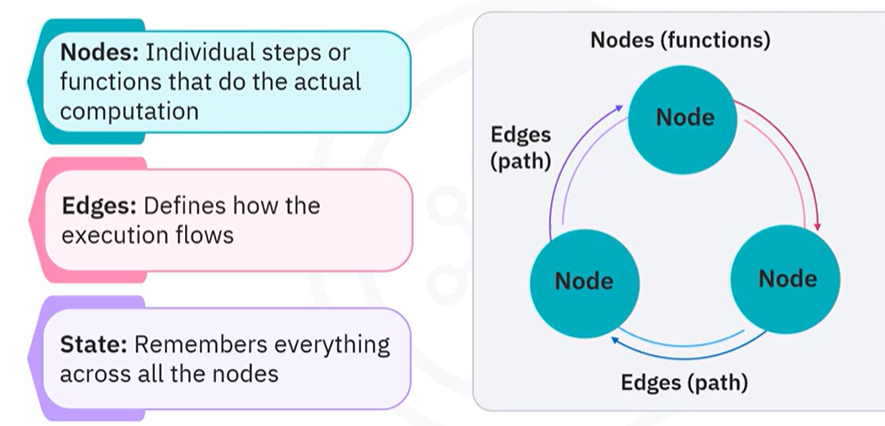

In langgraph the logic is expressed as nodes (functions or actions), edges (transitions), and states (persistent data)

## 📊 States: The Memory System

State is the shared memory that flows through your graph, carrying information between nodes and maintaining context.

### State Characteristics:

- **Persistent**: Survives across node executions
- **Shareable**: All nodes can read and modify state
- **Structured**: Defined schema ensures consistency
- **Versioned**: Can track changes over time


In [11]:
rag_state = {"user_question": "What happened between Milos and Ireena?",
             "documents": "",
             "llm_response": ""}  

In [12]:
from typing import TypedDict

class RagState(TypedDict):
    user_question: str
    documents: str 
    llm_response: str


## 🟢 Nodes: The Building Blocks
Nodes are the fundamental units of computation in LangGraph. Each node represents a specific function or operation.

### What Nodes Do:

- **Process Information**: Take the current state and perform operations
- **Make Decisions**: Determine what should happen next
- **Call Tools**: Interact with external APIs, databases, or services
- **Transform Data**: Modify or enrich the application state


In [13]:
from pydantic import BaseModel

class RagResponse(BaseModel):
    assistant_response: str

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def retriever_node(state: RagState) -> RagState:

    user_question = state.get("user_question")

    docs = retriever.get_relevant_documents(user_question)

    return {
        "documents": format_docs(docs)
    }

def llm_node(state: RagState) -> RagState:

    llm_chain = (
        {
            "context": lambda x: x["documents"], 
            "question": lambda x: x["user_question"]
        }
        | custom_rag_prompt
        | llm.with_structured_output(RagResponse)
    )

    llm_response = llm_chain.invoke(state)
    return {
        "llm_response": llm_response.assistant_response,
    }


## ➡️ Edges: The Flow Control

Edges define how execution flows between nodes, creating the graph structure and enabling complex routing logic.

### Types of Edges:

#### 🔗 Normal Edges
Direct connection from one node to another

#### 🔀 Conditional Edges
Route based on state content or conditions


In [16]:
from langgraph.constants import START, END
from langgraph.graph import StateGraph

graph = StateGraph(RagState)

# 1. Declare all the nodes in the graph
graph.add_node("Retriever_Node", retriever_node)
graph.add_node("LLM_Node", llm_node)

# 2. Declare the edges between the nodes
graph.add_edge(START, "Retriever_Node")
graph.add_edge("Retriever_Node", "LLM_Node")
graph.add_edge("LLM_Node", END)

compiled_graph = graph.compile()

state = RagState(
    user_question="What happened between Milos and Ireena?"
)

result = compiled_graph.invoke(state)

print(result["llm_response"])

D:\Projects\IntelliJ\ai-internship-2025\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Milos and Ireena share a complex history marked by deep emotional undercurrents. Ireena once harbored a childhood crush on Milos but never expressed her feelings. Milos, on the other hand, has confessed that he is in love with Ireena, a revelation that surprised their group. Despite this, Ireena is embarrassed and reluctant to discuss these feelings, especially after Ziva's teasing remarks. Their relationship is tinged with nostalgia, regret, and unspoken emotions amidst the darker events they face.


In [23]:
from PIL import Image as img
from langchain_core.runnables.graph import MermaidDrawMethod
from io import BytesIO

def show_graph(graph):
    image_binary = graph.get_graph().draw_mermaid_png(
        draw_method=MermaidDrawMethod.API,
    )
    image = img.open(BytesIO(image_binary))

    image.show()

show_graph(compiled_graph)

## 🔀 Conditional Edges: Dynamic Routing


In [26]:
from typing import TypedDict
class RagState(TypedDict):
    user_question: str
    documents: str 
    llm_response: str  
    is_relevant: bool

In [27]:
check_relevancy_template = """
Your role is to check if the user's question is relevant to Dungeons & Dragons and specifically the Curse of Strahd campaign.

Answer with a json object with a single boolean field "is_relevant" set to true or false.

Set "is_relevant" to true if the user's question is related to Dungeons & Dragons and the Curse of Strahd campaign:
- uses terminology from Dungeons & Dragons
- references characters, locations, or events from the Curse of Strahd campaign
- is about role-playing, game mechanics, or storytelling

Set "is_relevant" to false if the user's question is general, unrelated to Dungeons & Dragons, or about other topics.

Example response:
{{"is_relevant": true}}


## User's Question:
{question}
"""

check_relevancy_prompt = PromptTemplate.from_template(check_relevancy_template)

class CheckRelevancyResponse(BaseModel):
    is_relevant: bool


def check_question_relevancy(state: RagState) -> RagState:

    llm_chain = (
            {
                "question": lambda x: x["user_question"]
            }
            | check_relevancy_prompt
            | llm.with_structured_output(CheckRelevancyResponse)
    )

    llm_response = llm_chain.invoke(state)
    return {
        "is_relevant": llm_response.is_relevant,
    }

In [36]:
from langgraph.constants import START, END
from langgraph.graph import StateGraph

def should_bypass_retrieval(state: RagState) -> str:
    """Decides which edge to take based on the rag_type."""
    if state.get("is_relevant"):
        return False
    else:
        return True

graph = StateGraph(RagState)

graph.add_node("Should_bypass_retriever_Node", check_question_relevancy)
graph.add_node("Retriever_Node", retriever_node)
graph.add_node("LLM_Node", llm_node)


graph.add_edge(START, "Should_bypass_retriever_Node")
graph.add_conditional_edges("Check_Relevancy_Node", should_bypass_retrieval,
                            path_map={
                                    False: "Retriever_Node",
                                    True: END
                            })

graph.add_edge("Retriever_Node", "LLM_Node")
graph.add_edge("LLM_Node", END)

compiled_graph = graph.compile()

show_graph(compiled_graph)


In [31]:
state = RagState(
    user_question="What happened between Milos and Ireena?",
    documents="",
    llm_response=""
)

result = compiled_graph.invoke(state)

print(result["llm_response"])

D:\Projects\IntelliJ\ai-internship-2025\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Milos and Ireena share a complex history marked by deep emotional undercurrents. Ireena once harbored a childhood crush on Milos but never expressed her feelings. Milos, on the other hand, has confessed that he is in love with Ireena, a revelation that surprised their group. Despite this, Ireena is embarrassed and reluctant to discuss these feelings, especially after Ziva's teasing remarks. Their relationship is tinged with nostalgia, regret, and unspoken emotions amidst the darker events they face.


In [33]:
state = RagState(
    user_question="Give me a recipe for apple pie.",
    documents="",
    llm_response=""
)

result = compiled_graph.invoke(state)

print(result["llm_response"])

## 🚀 Enhanced RAG - Query Rewriting node

**Problem**: Sometimes users ask questions in ways that don't match how information is stored in documents.

**Solution**: **Query Rewriting** - Transform user queries into better search terms!

### 🔄 How Query Rewriting Works:
1. **User Question**: "What are Sally's abilities?" (might be too vague)
2. **LLM Rewriting**: "What are Sally's magical powers, combat skills, and special abilities in the Curse of Strahd campaign?"
3. **Better Retrieval**: More specific query = better document matches
4. **Better Answers**: More relevant context = higher quality responses

### 💡 Why This Helps:
- **Bridges Language Gap**: User casual language → Document formal language
- **Adds Context**: Includes domain-specific terms (D&D, Curse of Strahd)
- **Improves Specificity**: Vague questions become detailed queries
- **Better Matching**: Embedding similarity improves with better queries

In [48]:
class RagState(TypedDict):
    user_question: str
    documents: str
    llm_response: str
    is_relevant: bool

In [49]:

from langchain_core.output_parsers import StrOutputParser

rewrite_template = """
You are a query rewriting expert.

All user queries are related to a Dungeons & Dragons campaign called Curse of Strahd.

Analyze the user's query and rewrite it to improve RAG document retrieval chances:
    - Make it more specific or more general as appropriate
    - Add synonyms or related terms
    - Rephrase to target likely document content
    - Do not include in the rewritten query the fact that the campaign is called Curse of Strahd or is related to the campaign, just use this information as context to improve the query

User query: {question}

Rewritten user query:"""
rewrite_query_prompt = PromptTemplate.from_template(rewrite_template)

def rewrite_query_node(state: RagState) -> RagState:
    """Rewrite the user query to be optimized for RAG retrieval."""

    user_question = state.get("user_question")

    rewrite_chain = rewrite_query_prompt | llm | StrOutputParser()

    # Test the rewrite chain
    rewritten_query = rewrite_chain.invoke({"question": user_question})
    print(f"Rewritten query: {rewritten_query}")

    return {
        "user_question": rewritten_query
    }

In [50]:
not_relevant_answer_template = """
You are a funny agent that always responds with a joke when the user's question is not relevant to Dungeons & Dragons or the Curse of Strahd campaign.

The user asked a question that is not relevant to Dungeons & Dragons or the Curse of Strahd campaign.
Respond to them in a funny way that you cannot answer that question and make a D&D joke about the topic they asked about.

Ex: Sorry, I can't help you with that recipe for apple pie because a goblin ate it. But did you know that in Dungeons & Dragons, a gelatinous cube would probably love to try it? After all, it's always looking for new things to digest!

User query: {question}

Answer:"""
not_relevant_answer_prompt = PromptTemplate.from_template(not_relevant_answer_template)

def not_relevant_answer_node(state: RagState) -> RagState:
    """Generate a funny response for non-relevant questions."""

    user_question = state.get("user_question")

    not_relevant_chain = not_relevant_answer_prompt | llm | StrOutputParser()

    funny_response = not_relevant_chain.invoke({"question": user_question})

    return {
        "llm_response": funny_response
    }

In [51]:
def conditional_edge(state: RagState) -> str:
    """Decides which edge to take based on the rag_type."""
    if state.get("is_relevant"):
        return "Rewrite_Query_Node"
    else:
        return "Not_Relevant_Answer_Node"

graph = StateGraph(RagState)

graph.add_node("Check_Relevancy_Node", check_question_relevancy)
graph.add_node("Not_Relevant_Answer_Node", not_relevant_answer_node)
graph.add_node("Rewrite_Query_Node", rewrite_query_node)
graph.add_node("Retriever_Node", retriever_node)
graph.add_node("LLM_Node", llm_node)


graph.add_edge(START, "Check_Relevancy_Node")
graph.add_conditional_edges("Check_Relevancy_Node", conditional_edge,
                            path_map={
                                "Rewrite_Query_Node": "Rewrite_Query_Node",
                                "Not_Relevant_Answer_Node": "Not_Relevant_Answer_Node"
                            })

graph.add_edge("Rewrite_Query_Node", "Retriever_Node")
graph.add_edge("Retriever_Node", "LLM_Node")
graph.add_edge("Not_Relevant_Answer_Node", END)
graph.add_edge("LLM_Node", END)

compiled_graph = graph.compile()

show_graph(compiled_graph)


In [52]:
state = RagState(
    user_question="What happened between Milos and Ireena?",
    documents="",
    llm_response=""
)

result = compiled_graph.invoke(state)

print(f"Response: {result['llm_response']}")

Rewritten query: What is the history and relationship between Milos and Ireena, including key events and interactions between the two characters?


D:\Projects\IntelliJ\ai-internship-2025\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Response: Milos and Ireena share a history rooted in mutual support, having been close during their earlier years. Ireena once harbored a childhood crush on Milos, though she never expressed these feelings, and now she no longer has romantic feelings for him but still feels a connection. Both have endured trauma inflicted by Strahd, with Milos recalling how Strahd tortured him after a failed rebellion at Castle Ravenloft before cruelly releasing him. They have shared moments of bonding over their past sufferings and the rare experience of sunlight, which they both find awe-inspiring. Their relationship is marked by a complex mix of past affection, shared hardship, and current emotional distance due to overwhelming circumstances.


In [53]:
state = RagState(
    user_question="What KPI should I track for my marketing campaign?",
    documents="",
    llm_response=""
)

result = compiled_graph.invoke(state)

print(f"Response: {result['llm_response']}")

Response: Sorry, I can't help you with marketing KPIs because my spellbook only covers fireballs and healing potions. But did you know that in Dungeons & Dragons, the only KPI a rogue tracks is "Knockouts Per Infiltration"? Stealth is the ultimate conversion rate!


## Add Message History

In [55]:
from typing import TypedDict, Annotated, Sequence

from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage
from langgraph.graph import add_messages, MessagesState

class RagState(TypedDict):
    documents: str
    # 👇 This tells LangGraph how to MERGE updates to this key.
    messages: Annotated[Sequence[BaseMessage], add_messages]

### Why do we annotate messages?
By default, LangGraph’s state update logic is “last write wins”: when a node returns a value for a state key, it overwrites whatever was there before.

That’s a bad default for chat transcripts. If each node had to return the entire conversation every time, a node that only wants to add one new message would accidentally nuke the history unless it manually carried everything forward.

add_messages changes the update behavior for the messages key from “overwrite” to “append”. With it, nodes can return only the delta (the new messages they’re adding), and LangGraph will append those to the running transcript.

What this achieves:

Without add_messages: returning {"messages": [new_msg]} replaces the entire list with just [new_msg]. History is lost.

With add_messages: returning {"messages": [new_msg]} appends to the existing list. History is preserved automatically.

Developer ergonomics: Nodes can be simple—just return the new messages they produce. No need to fetch, merge, and re-emit the whole list on every hop.

In [56]:
def retriever_node(state: RagState) -> RagState:

    user_question = state.get("messages")[-1].content

    docs = retriever.get_relevant_documents(user_question)

    return {
        "documents": format_docs(docs)
    }


def llm_node(state: RagState) -> RagState:

    system_prompt = f"""
    ## Role
    You are Dungeon Master's assistant for the Curse of Strahd campaign they are writing and running.
    Use the following pieces of retrieved context to answer the user's question.

    ## Context:
    {state["documents"]}

    ---

    The context contains parts of the session notes written by the players as well as information taken from lore documents and DM documents.
    If you can't answer user's question base on the information provided in the context, say that you don't know, don't try to make up an answer.
    Include all relevant information but limit the response to 5 sentences.
    """

    full_prompt = [SystemMessage(system_prompt)] + state["messages"]

    llm_response = llm.invoke(full_prompt)

    return {
        "messages": [llm_response]
    }

In [57]:
graph = StateGraph(RagState)

graph.add_node("Retriever_Node", retriever_node)
graph.add_node("LLM_Node", llm_node)


graph.add_edge(START, "Retriever_Node")
graph.add_edge("Retriever_Node", "LLM_Node")
graph.add_edge("LLM_Node", END)

compiled_graph = graph.compile()

show_graph(compiled_graph)


In [58]:
from langchain_core.messages import HumanMessage

state = RagState(
    messages=[HumanMessage("What is Strahd's goal?")],
)

result = compiled_graph.invoke(state)

# print all the messages
for message in result["messages"]:
    message.pretty_print()

D:\Projects\IntelliJ\ai-internship-2025\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


================================ Human Message =================================

What is Strahd's goal?
================================== Ai Message ==================================

Strahd's primary goal is to free himself and Barovia from the Mists. He seeks to restore his long-lost empire, with Castle Ravenloft and the valley of Barovia as its seat of power. To achieve this, he needs a pacified kingdom, a host of loyal servants, and most importantly, an escape plan. He aims to break the town of Vallaki and the village of Krezk, discipline the Keepers of the Feather, and capture the vampire hunter Dr. Rudolph van Richten. Ultimately, Strahd wants to rule over a faithful and fearful populace subservient to him once more.


In [59]:
from langchain_core.messages import HumanMessage, AIMessage

state = RagState(
    messages=[HumanMessage("What is Strahd's goal?"),
              AIMessage("Strahd's primary goal is to free himself and Barovia from the Mists. He desires to restore his long-lost empire, with Castle Ravenloft and the valley of Barovia as its seat of power. To achieve this, he needs a pacified kingdom, loyal servants, and most importantly, an escape plan. He is working to break the town of Vallaki and the village of Krezk, discipline the Keepers of the Feather, and capture the vampire hunter Dr. Rudolph van Richten. Ultimately, Strahd aims to rule over a faithful and fearful populace subservient to him once more."),
              HumanMessage("What's his relationship to Tian?")],
)

result = compiled_graph.invoke(state)

# print all the messages
for message in result["messages"]:
    message.pretty_print()

D:\Projects\IntelliJ\ai-internship-2025\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


================================ Human Message =================================

What is Strahd's goal?
================================== Ai Message ==================================

Strahd's primary goal is to free himself and Barovia from the Mists. He desires to restore his long-lost empire, with Castle Ravenloft and the valley of Barovia as its seat of power. To achieve this, he needs a pacified kingdom, loyal servants, and most importantly, an escape plan. He is working to break the town of Vallaki and the village of Krezk, discipline the Keepers of the Feather, and capture the vampire hunter Dr. Rudolph van Richten. Ultimately, Strahd aims to rule over a faithful and fearful populace subservient to him once more.
================================ Human Message =================================

What's his relationship to Tian?
================================== Ai Message ==================================

The provided context does not include any information about Strahd's r

### Wait What?
Now that we have history the LLM should be able to understand and answer follow-up questions.
I'm sure we have information about that in the documents!

In [60]:
state = RagState(
    messages=[HumanMessage("What's the relationship between Strahd and Tian")],
)

result = compiled_graph.invoke(state)

# print all the messages
for message in result["messages"]:
    message.pretty_print()

D:\Projects\IntelliJ\ai-internship-2025\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


================================ Human Message =================================

What's the relationship between Strahd and Tian
================================== Ai Message ==================================

Tian is not a servant of Strahd and actively distances himself from the vampire lord. While Tian expresses some sympathy for Strahd, relating to the burden of familial expectations, he chose to flee rather than become a weapon like Strahd did. Tian does not see Strahd as the ultimate enemy, believing Strahd cannot truly be killed, and instead focuses his efforts against the Dark Powers controlling Barovia. His allegiance lies with the Shards of Dawn, and he is committed to freeing Barovia by opposing these greater forces rather than Strahd directly. The relationship is thus complex—Tian understands Strahd's tragic nature but opposes his dominion and the Dark Powers behind it.


### So yes we have information about Tian in the documents.
So what's the actual problem here?
Let's check what query was used to retrieve documents.

In [61]:
def retriever_node(state: RagState) -> RagState:

    user_question = state.get("messages")[-1].content

    print("User question for retrieval:", user_question)

    docs = retriever.get_relevant_documents(user_question)

    print("Documents:", docs)

    return {
        "documents": format_docs(docs)
    }

graph = StateGraph(RagState)

graph.add_node("Retriever_Node", retriever_node)
graph.add_node("LLM_Node", llm_node)


graph.add_edge(START, "Retriever_Node")
graph.add_edge("Retriever_Node", "LLM_Node")
graph.add_edge("LLM_Node", END)

compiled_graph = graph.compile()

show_graph(compiled_graph)

In [62]:
from langchain_core.messages import HumanMessage, AIMessage

state = RagState(
    messages=[HumanMessage("What is Strahd's goal?"),
              AIMessage("Strahd's primary goal is to free himself and Barovia from the Mists. He desires to restore his long-lost empire, with Castle Ravenloft and the valley of Barovia as its seat of power. To achieve this, he needs a pacified kingdom, loyal servants, and most importantly, an escape plan. He is working to break the town of Vallaki and the village of Krezk, discipline the Keepers of the Feather, and capture the vampire hunter Dr. Rudolph van Richten. Ultimately, Strahd aims to rule over a faithful and fearful populace subservient to him once more."),
              HumanMessage("What's his relationship to Tian?")],
)

result = compiled_graph.invoke(state)

# print all the messages
for message in result["messages"]:
    message.pretty_print()

User question for retrieval: What's his relationship to Tian?


D:\Projects\IntelliJ\ai-internship-2025\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Documents: [Document(metadata={'source': 'docs\\Curse of Strahd.md'}, page_content='Tian is a 23-year-old aarakocra with a commanding presence, standing tall with sleek black plumage accented by striking blue tips. His vivid turquoise eyes reflect both intensity and a quiet yearning. His wings are clipped, a practice instilled by his uncle as part of his martial training. Born into a noble family, Tian’s life has been shaped by a duality of purpose. While raised to inherit the responsibilities of his lineage, he was also trained from a young age in martial arts under his'), Document(metadata={'source': 'docs\\Curse of Strahd.md'}, page_content='As the battle ends, Izek approaches Tian, his expression filled with astonishment. Once again, he exclaims that this cannot be possible, before revealing that he has been waiting for Tian for a long time. Tian is caught off guard, accustomed to fear or suspicion from the people of Barovia, not this stunned reverence. When he voices his confusion

### There's out problem!
The retriever is using the last user message "Tell me more about his relationship to Tian"
to retrieve documents.
But that message doesn't contain enough context for the retriever to find relevant documents.

In order to fix this we need to add a Query Rewriting node before the retriever
that will use the full message history to rewrite the last user message into a better query.

In [73]:
rewrite_template = """
You are a query rewriting expert.

Check message history below and the Last User Query.
Rewrite the user's last query to be completely standalone without the need of the message history to be understood.

## Conversation History:
{history}


## Last User query:

{question}

Rewritten last user query:"""
rewrite_query_prompt = PromptTemplate.from_template(rewrite_template)

def rewrite_query_node(state: RagState) -> RagState:
    """Rewrite the user query to be optimized for RAG retrieval."""

    user_question = state.get("messages")[-1].content

    rewrite_chain = rewrite_query_prompt | llm | StrOutputParser()

    message_history = "\n".join(
        f"{msg.type.capitalize()}: {msg.content}" for msg in state.get("messages")[:-1]
    )

    # Test the rewrite chain
    rewritten_query = rewrite_chain.invoke({"question": user_question, "history": message_history})

    return {
        "rewritten_query": rewritten_query
    }

# We replace the retriever node to use the rewritten query from state
def retriever_node(state: RagState) -> RagState:

    user_question = state.get("rewritten_query")

    print("User question for retrieval:", user_question)

    docs = retriever.get_relevant_documents(user_question)

    print("Documents:", docs)

    return {
        "documents": format_docs(docs)
    }

In [74]:
class RagState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    documents: str
    rewritten_query: str

graph = StateGraph(RagState)

graph.add_node("Rewrite_Query", rewrite_query_node)
graph.add_node("Retriever_Node", retriever_node)
graph.add_node("LLM_Node", llm_node)


graph.add_edge(START, "Rewrite_Query")
graph.add_edge("Rewrite_Query", "Retriever_Node")
graph.add_edge("Retriever_Node", "LLM_Node")
graph.add_edge("LLM_Node", END)

compiled_graph = graph.compile()

In [76]:
from langchain_core.messages import HumanMessage, AIMessage

state = RagState(
    messages=[HumanMessage("What is Strahd's goal?"),
              AIMessage("Strahd's primary goal is to free himself and Barovia from the Mists. He desires to restore his long-lost empire, with Castle Ravenloft and the valley of Barovia as its seat of power. To achieve this, he needs a pacified kingdom, loyal servants, and most importantly, an escape plan. He is working to break the town of Vallaki and the village of Krezk, discipline the Keepers of the Feather, and capture the vampire hunter Dr. Rudolph van Richten. Ultimately, Strahd aims to rule over a faithful and fearful populace subservient to him once more."),
              HumanMessage("What's his relationship to Tian?")],
)

result = compiled_graph.invoke(state)

# print all the messages
for message in result["messages"]:
    message.pretty_print()

User question for retrieval: What is Strahd's relationship to Tian?


D:\Projects\IntelliJ\ai-internship-2025\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Documents: [Document(metadata={'source': 'docs\\Curse of Strahd.md'}, page_content='Tian argues once more that the Tome did not need to be destroyed. It contained vital information and a detailed history of what had come to pass. He expresses a degree of sympathy toward Strahd, revealing that he, too, was raised under the weight of familial expectations. Unlike Strahd, however, Tian chose to flee rather than become a weapon for his family.'), Document(metadata={'source': 'docs\\Curse of Strahd.md'}, page_content='Meanwhile, Sally has been pressing Tian to clarify his earlier statement—that he doesn’t see Strahd as the enemy. Tian reiterates his position. He does not believe Strahd can be truly killed, which is why he has shifted his focus to the Dark Powers themselves. He no longer places his faith in gods or their shadows, but in people. His allegiance lies with the Shards of Dawn, and he is committed to doing whatever it takes to free Barovia.'), Document(metadata={'source': 'docs\\C

## So now it works. But it seems we have to manage history manually by storing it between calls. Something like this:

In [78]:
# manual history management that we want to avoid

user_question = input("User: ")
messages = []
while user_question.lower() != "exit":
    state = RagState(
        messages=messages + [HumanMessage(user_question)],
    )

    result = compiled_graph.invoke(state)

    # print all the messages
    for message in result["messages"]:
        message.pretty_print()

    messages = result["messages"]
    user_question = input("User: ")

User question for retrieval: Who is Strahd?


D:\Projects\IntelliJ\ai-internship-2025\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Documents: [Document(metadata={'source': 'docs\\Curse of Strahd.md'}, page_content='Their search leads them to a clearing where a regal figure sits on a tree stump, the natural wood shaped eerily like a throne. The man exudes an aura of power and authority, his presence commanding immediate attention. He introduces himself as Lord Strahd von Zarovich, ruler of these lands. Ziva and Gavin offer polite introductions in return, wary but respectful.'), Document(metadata={'source': 'docs\\Curse of Strahd.md'}, page_content="Aided by a sect of the druids, Strahd's conquest was successful. He was named governor of the valley, which he named Barovia after his father. He began construction on a great castle with the assistance of his court wizard and chief architect, Kazahn, and introduced Morninglord worship to the valley."), Document(metadata={'source': 'docs\\Curse of Strahd.md'}, page_content='As the party regains consciousness and begins to gather their bearings, they look up to find Strah

D:\Projects\IntelliJ\ai-internship-2025\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Documents: [Document(metadata={'source': 'docs\\History of Barovia.md'}, page_content='Birth of Barovia\n\nKing Barov did not live to see the fruits of his labors. When he passed into death, Strahd inherited his lands and enemies and vowed to finish what his father had started. Though he had been Barov’s heir, Strahd did not name himself king; instead, he deferred the ancient crown of Zarovia, keeping it in a chest carried by his attendants. A kingdom was not enough—Strahd dreamed of forging an empire.'), Document(metadata={'source': 'docs\\Curse of Strahd.md'}, page_content='Barovia: a mysterious and unsettling land, shrouded in mist and isolated from the world beyond. The sky is perpetually overcast, and a heavy sense of foreboding hangs in the air. The landscape is dominated by jagged mountains that loom over dense forests and crumbling villages. The land feels old, as if trapped in time, and every corner seems to whisper of ancient secrets and long-forgotten horrors. Barovia is a p

## 🧠 Built-in Memory Management from LangGraph
LangGraph provides built-in memory management to handle message history automatically across multiple invocations.
This means you don't have to manually pass the entire conversation history each time you invoke the graph.


In [80]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
compiled_graph = graph.compile(checkpointer=memory)

# Specify an ID for the thread
config = {"configurable": {"thread_id": "abc123"}}

In [81]:
user_question = input("User: ")
while user_question.lower() != "exit":

    human_message = HumanMessage(user_question)
    human_message.pretty_print()

    state = RagState(
        messages=[human_message],
    )
    result = compiled_graph.invoke(state, config=config)
    result["messages"][-1].pretty_print()
    user_question = input("User: ")

================================ Human Message =================================

who's strahd
User question for retrieval: Who is Strahd?


D:\Projects\IntelliJ\ai-internship-2025\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Documents: [Document(metadata={'source': 'docs\\Curse of Strahd.md'}, page_content='Their search leads them to a clearing where a regal figure sits on a tree stump, the natural wood shaped eerily like a throne. The man exudes an aura of power and authority, his presence commanding immediate attention. He introduces himself as Lord Strahd von Zarovich, ruler of these lands. Ziva and Gavin offer polite introductions in return, wary but respectful.'), Document(metadata={'source': 'docs\\Curse of Strahd.md'}, page_content="Aided by a sect of the druids, Strahd's conquest was successful. He was named governor of the valley, which he named Barovia after his father. He began construction on a great castle with the assistance of his court wizard and chief architect, Kazahn, and introduced Morninglord worship to the valley."), Document(metadata={'source': 'docs\\Curse of Strahd.md'}, page_content='As the party regains consciousness and begins to gather their bearings, they look up to find Strah

D:\Projects\IntelliJ\ai-internship-2025\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Documents: [Document(metadata={'source': 'docs\\Strahd von Zarovich.md'}, page_content="In this role, Strahd most often feels curious, amused, nostalgic, or disappointed. Consider channeling Hannibal Lecter (The Silence of the Lambs), Don Corleone (The Godfather), or Frank Underwood (House of Cards) when playing him.\n\nThe Gentleman avoids clashes as much as he can, taking any player rudeness or defiance in stride. If pushed, he might send his minions to stop a player's physical attacks, but only as a last resort.\n\nThe Tyrant"), Document(metadata={'source': 'docs\\Lore of Barovia.md'}, page_content='Strahd is not the villain of Curse of Strahd because he is powerful; he is the villain because he is a cruel, prideful, and deeply personal antagonist. To remove him as the final boss of his own campaign would both weaken the tragic themes that underly it and, more importantly, cheapen the relationship that the players have developed with him throughout the course of the adventure.'), Do

D:\Projects\IntelliJ\ai-internship-2025\.venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'localhost'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Documents: [Document(metadata={'source': 'docs\\Curse of Strahd.md'}, page_content='With the conversation shifting, Ziva inquires about the officiant of the wedding ceremony. Andral explains that he has long since passed the responsibility to younger clerics. The one performing the ceremony will be Elona, and if the party seeks further insight, they should speak with her directly.\n\nWith that, the conversation reaches its natural end. Ziva and Milos thank Andral for his time before parting ways.'), Document(metadata={'source': 'docs\\Curse of Strahd.md'}, page_content='declaring Sally irrelevant for now. The tattoo cools, ending the exchange.'), Document(metadata={'source': 'docs\\Curse of Strahd.md'}, page_content="plea. “Your terms are not acceptable” he declares before ending the elf's life.")]
================================== Ai Message ==================================

If you need any further assistance with your Curse of Strahd campaign or have more questions later, feel fre

KeyboardInterrupt: Interrupted by user